In [2]:
!rm 2016.* # remove any downloaded data 
!wget http://104.197.136.14/ds/2016.04/2016.04C.multisnr.pkl.bz2
!apt-get -qq install dtrx # download the extractor silently
!dtrx 2016.04C.multisnr.pkl.bz2

rm: cannot remove '2016.*': No such file or directory
--2018-05-10 22:26:45--  http://104.197.136.14/ds/2016.04/2016.04C.multisnr.pkl.bz2
Connecting to 104.197.136.14:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111458161 (106M) [application/x-bzip2]
Saving to: ‘2016.04C.multisnr.pkl.bz2’

2016.04C.multisnr.p 100%[===================>] 106.29M  23.9MB/s    in 4.7s    

2018-05-10 22:26:50 (22.8 MB/s) - ‘2016.04C.multisnr.pkl.bz2’ saved [111458161/111458161]

Selecting previously unselected package liblzo2-2:amd64.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../00-liblzo2-2_2.08-1.2_amd64.deb ...
Unpacking liblzo2-2:amd64 (2.08-1.2) ...
Selecting previously unselected package p7zip.
Preparing to unpack .../01-p7zip_16.02+dfsg-4_amd64.deb ...
Unpacking p7zip (16.02+dfsg-4) ...
Selecting previously unselected package p7zip-full.
Preparing to unpack .../02-p7zip-full_16.02+dfsg-4_amd64.deb ...
Unpacking p7zip-full 

In [ ]:
!pip install pydot 
# this is used to plot the neural network

In [ ]:
!pip install -U -q PyDrive

  Created wheel for google-colab: filename=google_colab-1.0.0-py2.py3-none-any.whl size=102299 sha256=e85b715b753a6348d4cb4911e132cd1cbe2a3e64593dfed52300c6479c2be363
  Stored in directory: C:\Users\KJJ\AppData\Local\pip\Cache\wheels\38\0d\59\701e300a337b2a2e07b27fe74dbfff0bc56ac58f711566ee67
  Created wheel for portpicker: filename=portpicker-1.2.0-cp37-none-any.whl size=13374 sha256=789e6e6240053c9cb3f90f84a9426424c518420c91083f0ae3c5748755e1e16d
  Stored in directory: C:\Users\KJJ\AppData\Local\pip\Cache\wheels\4a\45\47\1e126be9d4605e71f00d6e6fb151611f2f4cb9770b050c7d2d
  Created wheel for tornado: filename=tornado-4.5.3-cp37-cp37m-win_amd64.whl size=427309 sha256=12bf22b2cf5e056fcd5804e830e5aa0181558ccea2e5f796906eaab8091e9bf8
  Stored in directory: C:\Users\KJJ\AppData\Local\pip\Cache\wheels\72\bf\f4\b68fa69596986881b397b18ff2b9af5f8181233aadcc9f76fd
Successfully built google-colab portpicker tornado
  Found existing installation: google-auth 1.7.2
    Uninstalling google-auth-1.7

ERROR: spyder-kernels 0.5.2 has requirement ipykernel>=4.8.2, but you'll have ipykernel 4.6.1 which is incompatible.
ERROR: jupyter-console 6.0.0 has requirement prompt_toolkit<2.1.0,>=2.0.0, but you'll have prompt-toolkit 1.0.18 which is incompatible.
ERROR: distributed 2.5.2 has requirement tornado>=5, but you'll have tornado 4.5.3 which is incompatible.
ERROR: Could not install packages due to an EnvironmentError: [WinError 5] 액세스가 거부되었습니다: 'd:\\anaconda3\\lib\\site-packages\\~ornado\\speedups.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



## **Imports**

In [1]:
%reset
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, BatchNormalization, LSTM, Conv1D, MaxPooling1D
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from scipy.interpolate import UnivariateSpline
from keras.utils import to_categorical
#from sklearn import preprocessing
from keras.optimizers import Adam
from keras import regularizers

#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials


plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Using TensorFlow backend.


In [2]:
from sklearn import preprocessing

## **loading the data into X and their labels in the form (modulation type, snr) into a list labels**

In [3]:
with open('2016.04C.multisnr.pkl','rb') as f:
  data = pickle.load(f,encoding='bytes')

In [4]:
X = []
labels = [] # label each example by a pair (modulation type, snr)
total_examples = 0
for mod_type, snr in data.keys():
  current_matrix = data[(mod_type, snr)]
  total_examples += current_matrix.shape[0]
  for i in range(current_matrix.shape[0]):
    X.append(current_matrix[i])
    labels.append((str(mod_type, 'ascii'), snr)) # mod_type is of type bytes
X = np.array(X)
labels = np.array(labels)
print(f'loaded {total_examples} signal vectors into X{X.shape} and their corresponding'
      f' labels into labels{labels.shape}')

loaded 162060 signal vectors into X(162060, 2, 128) and their corresponding labels into labels(162060, 2)


## **Computing different features**

In [8]:
def apply_per_channel(X, func, verbose=False):
  X_out = np.empty_like(X)
  for i in range(X.shape[0]):
    first_channel = np.expand_dims(func(X[i][0]), axis=0) 
    second_channel = np.expand_dims(func(X[i][1]), axis=0)
    X_out[i] = np.concatenate((first_channel, second_channel), axis=0)
    if verbose:
      print(f'done with example {i}')
      
  return X_out
def grad(chan):
  return np.concatenate((np.diff(chan),np.zeros(1))) 

X_der = apply_per_channel(X,grad)
print(f'computed derivative per channel, output shape={X_der.shape}')

computed derivative per channel, output shape=(162060, 2, 128)


In [0]:
# this takes some time, should be saved to save time
def antiderivative(vec):
  time_steps = np.arange(128)*1e-6
  antider = UnivariateSpline(time_steps, vec, s=10).antiderivative()
  return antider(time_steps) 

  
  
# X_int = apply_per_channel(X, antiderivative, False)
# print(f'computed antiderivative per channel, output shape={X_int.shape}')

# print(antiderivative(X[0,0,:]))
# print(X[0,0,:])


In [0]:
X_int = np.empty((10,10))
np.save("antidrev",X_int)

In [12]:
def get_fft_channel(X):
  cplx_X = 1j*X[:,1,:] + X[:,0,:]
  X_fft = np.empty_like(cplx_X).astype('float32')
  for i in range(X.shape[0]):
    X_fft[i] = np.absolute(np.fft.fft(cplx_X[0]))
        
  return X_fft.reshape(X_fft.shape[0], 1, X_fft.shape[1])

X_fft, freq_axis = get_fft_channel(X), np.fft.fftfreq(128)
print(f'computed the fft of the signals, X_fft{X_fft.shape}')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


computed the fft of the signals, X_fft(162060, 1, 128)


**A utility to mix features from the feature battery**

In [0]:
feature_battery = {'raw':X, 'derivative':X_der, 'integration':X_int, 'fft':X_fft}
def combine_features(*feature_names):
  return np.concatenate([feature_battery[feature] for feature in feature_names], axis=1)


In [0]:
X_2= combine_features('derivative')
X_3 = combine_features('raw','fft')
X_123 = combine_features('raw','derivative','fft')

In [15]:
print(X_2.shape)
print(X_3.shape)
print(X_123.shape)

(162060, 2, 128)
(162060, 3, 128)
(162060, 5, 128)


### **Variables used for training the models**

In [9]:
# take 20% of the data for testing and 10% of training for validation
TEST_PERCENTAGE = 0.2
VALIDATION_PERCENTAGE = 0.05

EPOCHS = 20
NUM_CLASSES = 11
BATCH_SIZE = 1024

## **Splitting the data into train, test and validation sets ** <br>
**labels is the vector of (mod_type, snr) while y is the vector of mod_types only we should train using y and then use labels to see how the classifiers performed on each of the different snr's**

In [10]:
def split_data(data, labels, percentage):
  perm_idx = np.random.permutation(labels.shape[0])
  data_perm = data[perm_idx]
  labels_perm = labels[perm_idx]
  split_point = int((1-percentage)*data_perm.shape[0])
  data_train = data_perm[0:split_point]
  data_test = data_perm[split_point:]
  labels_train = labels_perm[0:split_point]
  labels_test = labels_perm[split_point:]
  y_train = labels_train[:,0]
  y_test = labels_test[:,0]
  return data_train, data_test, labels_train, labels_test, y_train, y_test


In [11]:
X_train, X_test, labels_train, labels_test, y_train, y_test = split_data(X,labels, TEST_PERCENTAGE)

print(f'shapes after train test split:\n'
      f'X_train{X_train.shape}, X_test{X_test.shape}, '
      f'labels_train{labels_train.shape}, labels_test{labels_test.shape}, '
      f'y_train{y_train.shape}, y_test{y_test.shape}')



shapes after train test split:
X_train(129648, 2, 128), X_test(32412, 2, 128), labels_train(129648, 2), labels_test(32412, 2), y_train(129648,), y_test(32412,)


In [19]:
X_devtrain, X_devtest, labels_devtrain, labels_devtest, y_devtrain, y_devtest = split_data(X_2,labels, TEST_PERCENTAGE)

print(f'shapes after train test split of derivative:\n'
      f'X_train{X_devtrain.shape}, X_test{X_devtest.shape}, '
      f'labels_train{labels_devtrain.shape}, labels_test{labels_devtest.shape}, '
      f'y_train{y_devtrain.shape}, y_test{y_devtest.shape}')


shapes after train test split of derivative:
X_train(129648, 2, 128), X_test(32412, 2, 128), labels_train(129648, 2), labels_test(32412, 2), y_train(129648,), y_test(32412,)


In [20]:
X_inttrain, X_inttest, labels_inttrain, labels_inttest, y_inttrain, y_inttest = split_data(X_3,labels, TEST_PERCENTAGE)

print(f'shapes after train test split of integration:\n'
      f'X_train{X_inttrain.shape}, X_test{X_inttest.shape}, '
      f'labels_train{labels_inttrain.shape}, labels_test{labels_inttest.shape}, '
      f'y_train{y_inttrain.shape}, y_test{y_inttest.shape}')


shapes after train test split of integration:
X_train(129648, 3, 128), X_test(32412, 3, 128), labels_train(129648, 2), labels_test(32412, 2), y_train(129648,), y_test(32412,)


In [21]:
X_comptrain, X_comptest, labels_comptrain, labels_comptest, y_comptrain, y_comptest = split_data(X_123,labels, TEST_PERCENTAGE)

print(f'shapes after train test split of integration:\n'
      f'X_train{X_comptrain.shape}, X_test{X_comptest.shape}, '
      f'labels_train{labels_comptrain.shape}, labels_test{labels_comptest.shape}, '
      f'y_train{y_comptrain.shape}, y_test{y_comptest.shape}')

shapes after train test split of integration:
X_train(129648, 5, 128), X_test(32412, 5, 128), labels_train(129648, 2), labels_test(32412, 2), y_train(129648,), y_test(32412,)


### *Helpers for generating and plotting confusion matrices**

In [12]:
 def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
def generate_confusion_matrix(model, X,y, one_hot_transformer, batch_size):
    """
      y is the one hot encoded label vector passed to the model.evaluate
    """
    mod_to_idx = {mod:idx for idx,mod in enumerate(one_hot_transformer.classes_)} # use this to map modulation name to index
    y_hat = model.predict(X, batch_size)
    y_hat_onehot = np.zeros_like(y_hat)
    y_hat_onehot[np.arange(len(y_hat)), y_hat.argmax(1)] = 1 # convert the probabilities to one-hot format
    y_hat_mod = one_hot_transformer.inverse_transform(y_hat_onehot) # transform predictions to strings
    y_mod = one_hot_transformer.inverse_transform(y) # transform ground truth back to strings
    confusion_mat = np.zeros([NUM_CLASSES,NUM_CLASSES])

    acc = np.mean(y_mod == y_hat_mod)
    # fill in the confusion matrix
    for i in range(X.shape[0]):
        
        true_idx = mod_to_idx[y_mod[i]]
        pred_idx = mod_to_idx[y_hat_mod[i]]          
        confusion_mat[pred_idx,true_idx] += 1

    # normalize the matrix row wise
    for i in range(NUM_CLASSES):
        if np.sum(confusion_mat[i,:]) > 0:
          confusion_mat[i,:] /= np.sum(confusion_mat[i,:])
    
    return confusion_mat,acc

 

**helper to save the model to google Drive**

In [0]:
# Authenticate and create the PyDrive client.

class GDriveSaver(Callback):
    def __init__(self, model_name):
      self.model_name = model_name
      auth.authenticate_user()
      self.gauth = GoogleAuth()
      self.gauth.credentials = GoogleCredentials.get_application_default()
      self.drive = GoogleDrive(self.gauth)
      
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 5 == 0 and epoch > 0:
          #Create folder
          folder_metadata = {'title' : 'assignment-3-models',
                             'mimeType' : 'application/vnd.google-apps.folder'}
          folder = self.drive.CreateFile(folder_metadata)
          folder.Upload()


          #Upload file to folder
          file_name = f'{self.model_name}-weights-{epoch}.hdf5'
          file = self.drive.CreateFile({'title': file_name, "parents": [{"kind": "drive#fileLink", "id": folder['id']}]})
          self.model.save_weights(file_name)
          file.SetContentFile(file_name)
          file.Upload()
          print(f'Uploaded file with ID {file.get("id")} and name {file_name}')

              

### **The function used to evaluate the models**

In [16]:

class ModelEvaluater:
  def __init__(self, model, X_train, y_train, X_test, y_test, 
               labels_test, labels, batch_size, num_partitions, model_name):
    self.model = model
    self.X_train = X_train
    self.y_train = y_train
    self.X_test = X_test
    self.y_test = y_test
    self.labels = labels
    self.labels_test = labels_test
    self.model_name = model_name
    self._curr_partition = 0
    self._partition_size = X_train.shape[0]//num_partitions
    self.num_partitions = num_partitions
    self._checkpoint_callback = ModelCheckpoint(filepath='%s-weights-{epoch}.hdf5' % self.model_name,
                                                verbose=1, save_best_only=True)
    self._train_accs = []
    self._val_accs = []
    self._snr_accs = []
    
    self.batch_size = batch_size
    
    
    # get the modulation types into an array
    self.mod_types = np.unique(labels[:,0])
  
    # fit a label binarizer 
    self.mod_to_onehot = preprocessing.LabelBinarizer()
    self.mod_to_onehot.fit(self.mod_types)

    # transform the y values to one-hot encoding
    self.y_train = self.mod_to_onehot.transform(y_train)
    self.y_test = self.mod_to_onehot.transform(y_test)
    
    print(f'y_train{y_train.shape}')
    print(f'y_test{y_test.shape}')
    

    
  def fit(self, epochs, val_percent=0.05, patience=4, fit_all=False, save_to_drive=False):
    curr_X, curr_y = None, None
    if fit_all:
      curr_X, curr_y = self.X_train, self.y_train
    else:
      idx_start, idx_end = self._curr_partition*self._partition_size, (self._curr_partition+1)*(self._partition_size)
      print(idx_start, idx_end, self._partition_size)
      curr_X, curr_y = self.X_train[idx_start:idx_end], self.y_train[idx_start:idx_end]
      self._curr_partition = (self._curr_partition + 1) % self.num_partitions

    callbacks = [self._checkpoint_callback, EarlyStopping(patience=patience)]
    if save_to_drive:
      callbacks.append(GDriveSaver(self.model_name))


     # train the model
    model_info = self.model.fit(curr_X, curr_y,
                                batch_size=self.batch_size,
                                epochs=epochs,
                                verbose=1,
                                validation_split=val_percent,
                                callbacks=callbacks)

    self._train_accs.extend(model_info.history['acc'])
    self._val_accs.extend(model_info.history['val_acc'])






  def print_summary(self):
    # plot validation accuracy vs training accuracy
    plt.plot(np.arange(len(self._train_accs)), self._train_accs, '-o', label='training accuracy')
    plt.plot(np.arange(len(self._val_accs)), self._val_accs, '-o', label='validation accuracy')
    plt.legend()
    plt.xlabel('epochs')
    plt.title(f'{self.model_name}-validation vs training accuracy')
    display(plt.show())

    # plot the confussion matrix for the whole test data
    conf_mat, avg_acc = generate_confusion_matrix(self.model, self.X_test,
                                                  self.y_test, self.mod_to_onehot, self.batch_size)
    plot_confusion_matrix(conf_mat, labels=self.mod_to_onehot.classes_,
                          title=f'{self.model_name} - conf mat for whole test data - acc={avg_acc * 100}%')
    plt.show()  
    # plot the confusion matrix per snr

    snr_accs = {}
    snrs = np.unique(np.unique(self.labels,axis=0)[:,1]).astype('int32')
    for snr in sorted(snrs):
      idx = np.where(self.labels_test[:,1]==str(snr))
      X_snr = self.X_test[idx]
      y_snr = self.y_test[idx]
      conf_mat, acc = generate_confusion_matrix(self.model, X_snr, y_snr, self.mod_to_onehot, self.batch_size)
      snr_accs[snr] = acc
      plot_confusion_matrix(conf_mat, labels=self.mod_to_onehot.classes_, 
                            title=f'{self.model_name}- Confusion Matrix (SNR={snr}) - acc={acc*100}%')
      plt.show()

    # plot the accuracy against the snr
    plt.plot(snr_accs.keys(),snr_accs.values(), '-o')
    plt.xlabel("Signal to Noise Ratio")
    plt.ylabel("Classification Accuracy")
    plt.xticks(list(snr_accs.keys()))
    plt.show()


## **Build and train a fully connected network as the baseline **

In [17]:
def build_fc_net(X1,X2):
  
  reg = 1e-3
  dropout = 0.2
  
  fc_model = Sequential()
  fc_model.add(Flatten('channels_first', input_shape=(X1,X2)))
  fc_model.add(Dense(186, activation='relu', kernel_regularizer=regularizers.l1(reg)))
  fc_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(reg)))
  fc_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1(reg)))
  fc_model.add(BatchNormalization())
  fc_model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l1(reg)))
  fc_model.add(Dropout(rate=dropout))
  fc_model.add(Dense(NUM_CLASSES, activation='softmax'))
  fc_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
  fc_model.summary()
  return fc_model

In [25]:
# raw features
fc_model = build_fc_net(X.shape[1],X.shape[2])
fc_model_evaluater = ModelEvaluater(fc_model, X_train, y_train, X_test, y_test, labels_test, labels, 1024, 10, 'fc-net' )
fc_model_evaluater.fit(30,fit_all= True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 186)               47802     
_________________________________________________________________
dense_17 (Dense)             (None, 128)               23936     
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_4 (Batch (None, 64)                256       
_________________________________________________________________
dense_19 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
__________


Epoch 00030: val_loss did not improve from 1.21063


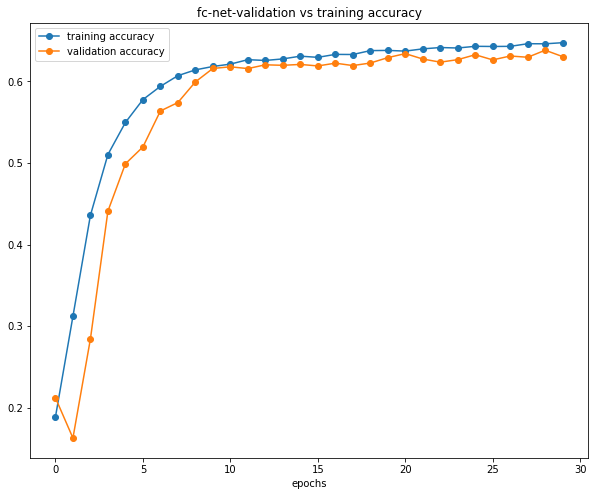

None

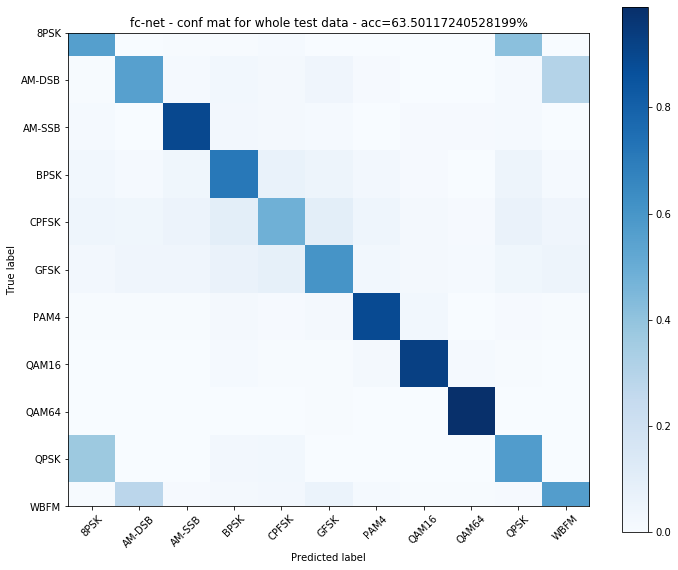

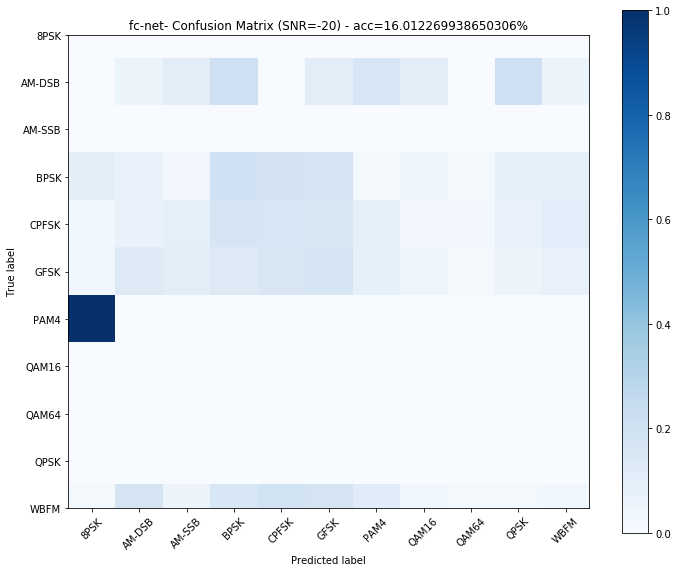

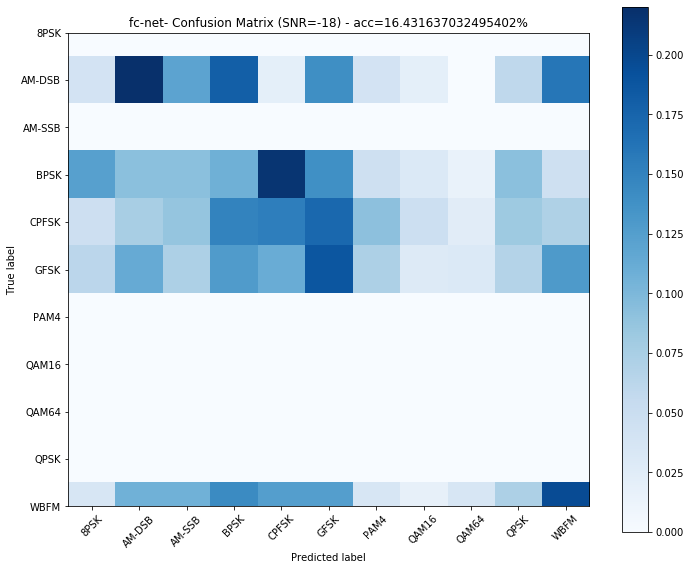

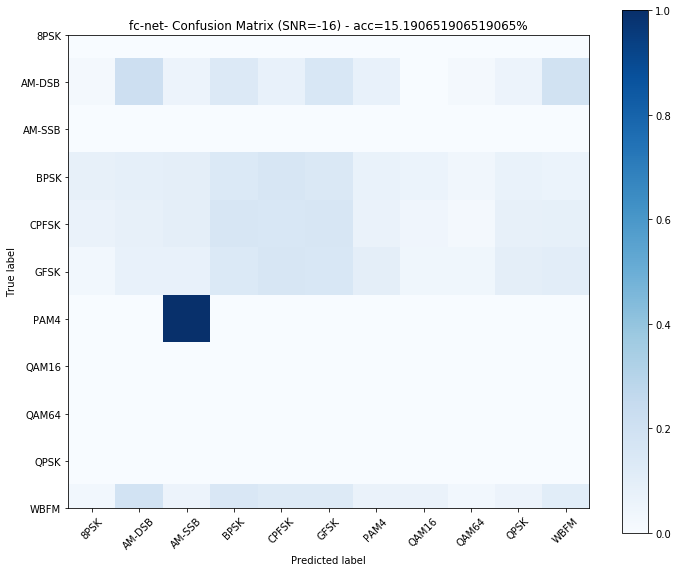

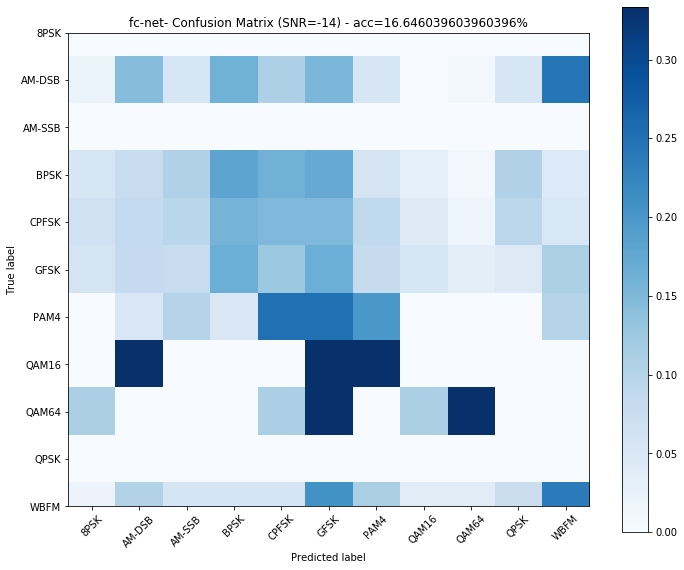

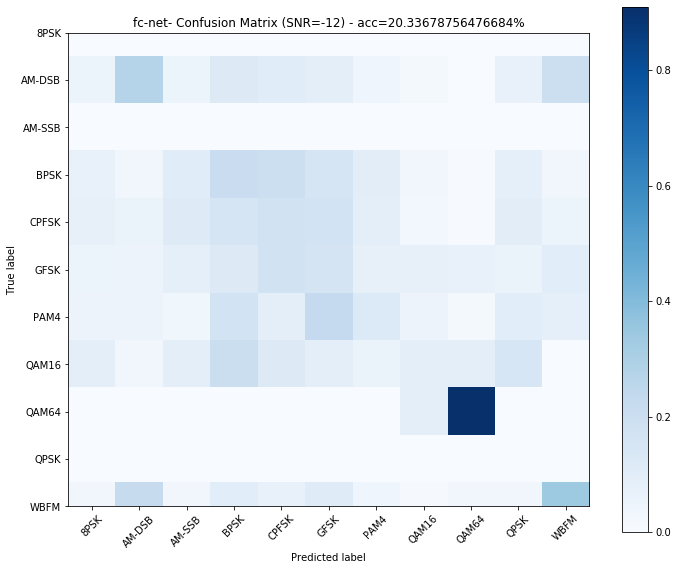

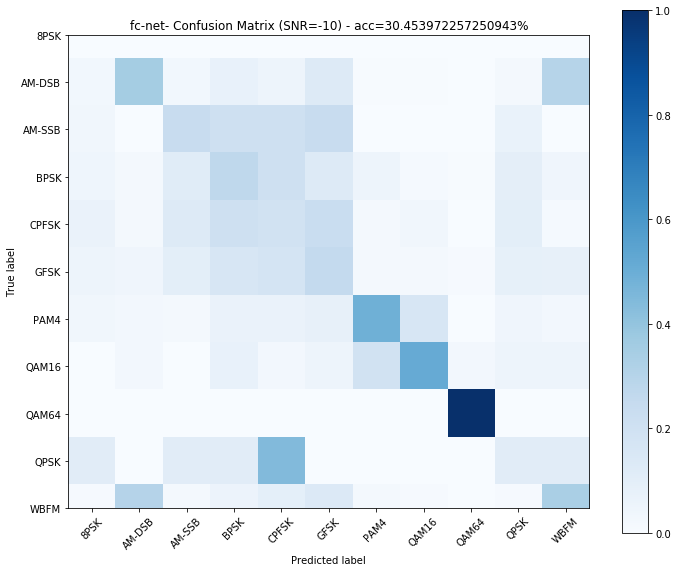

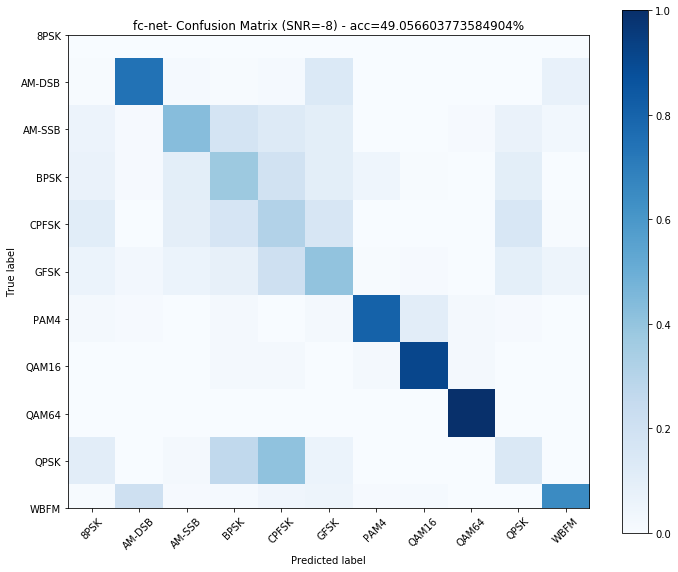

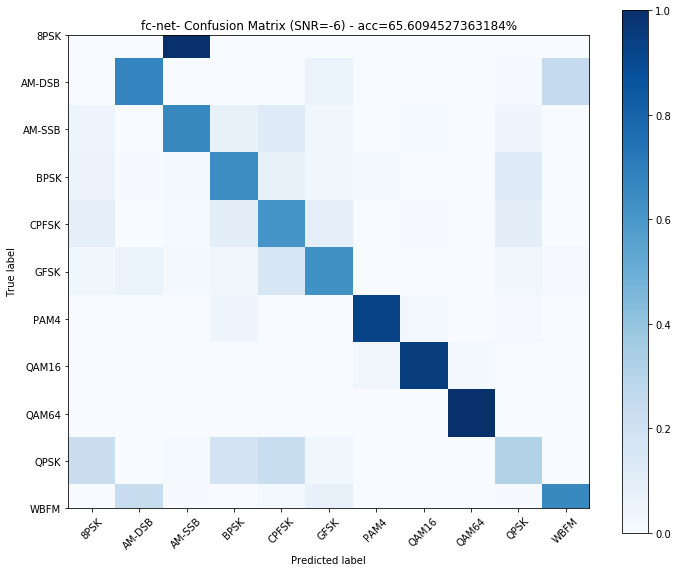

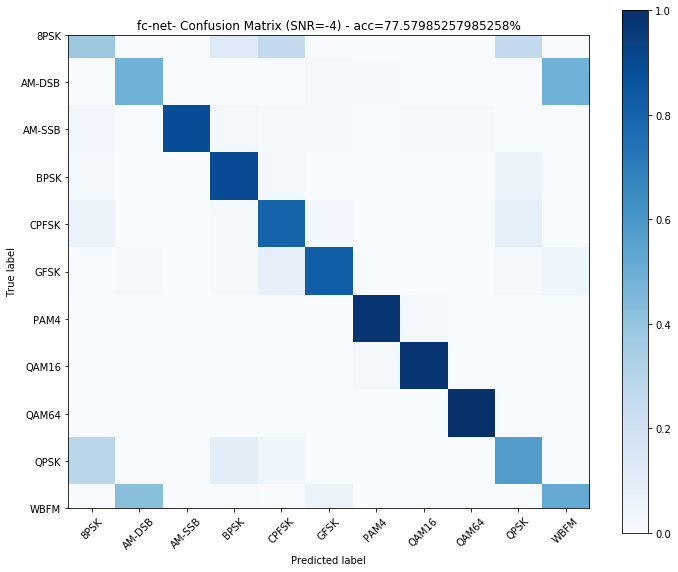

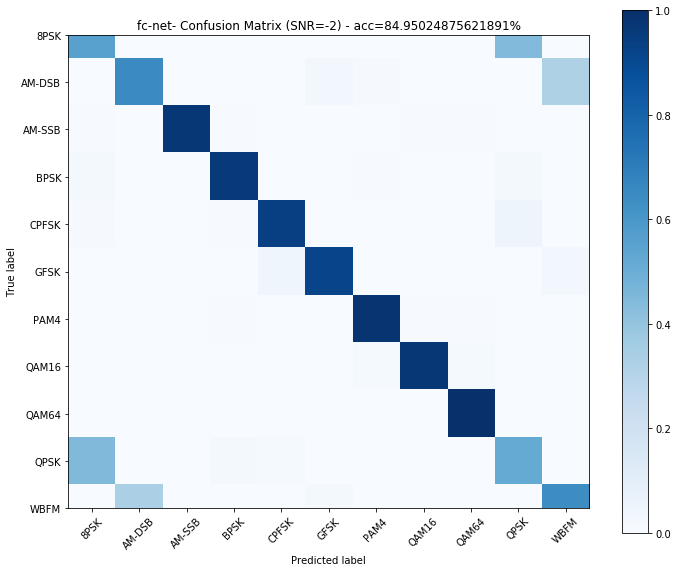

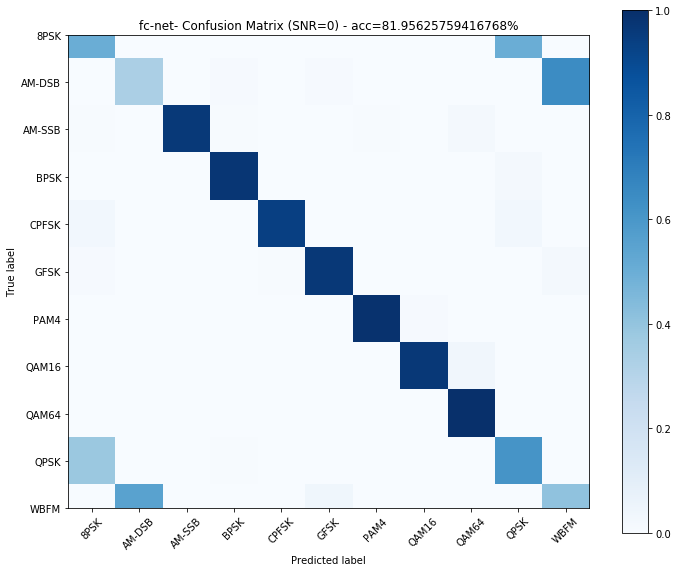

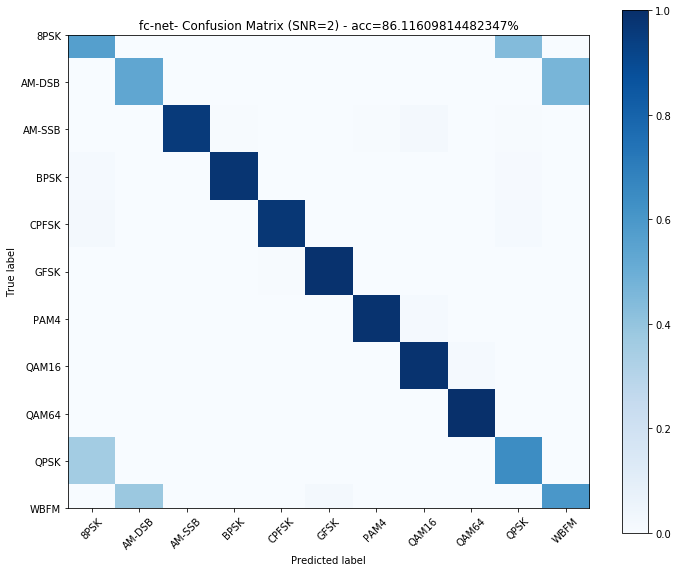

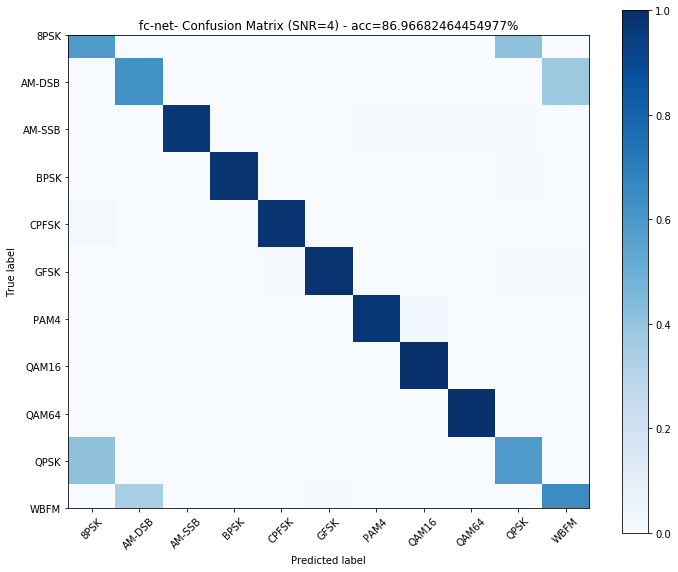

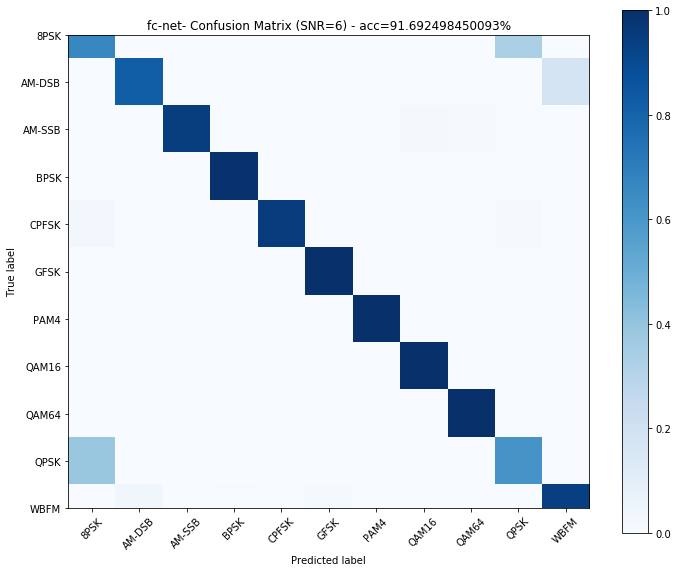

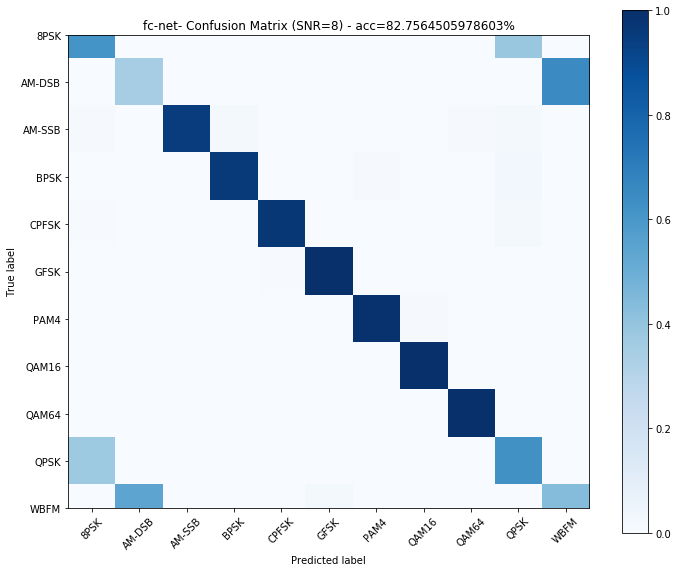

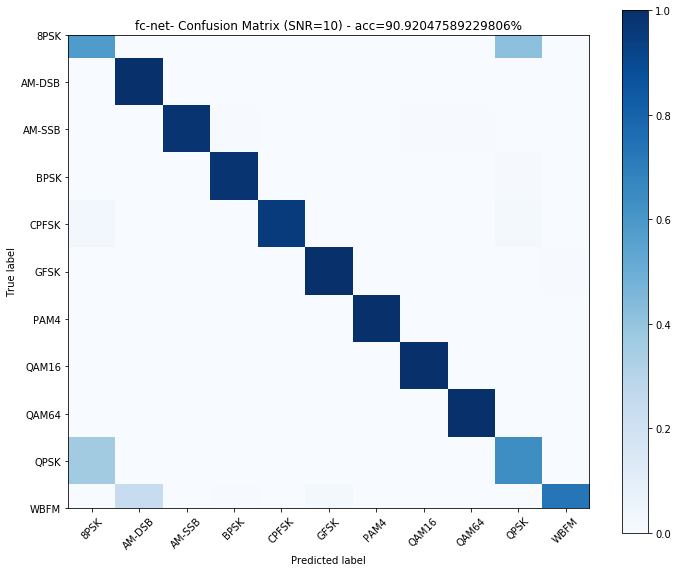

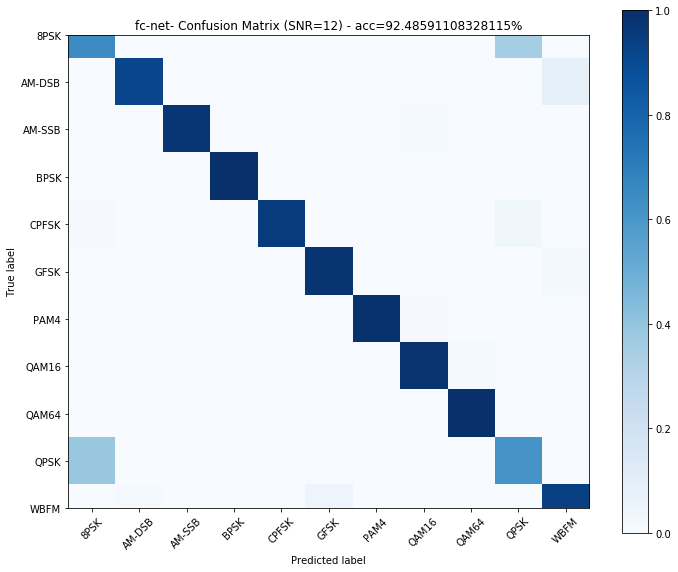

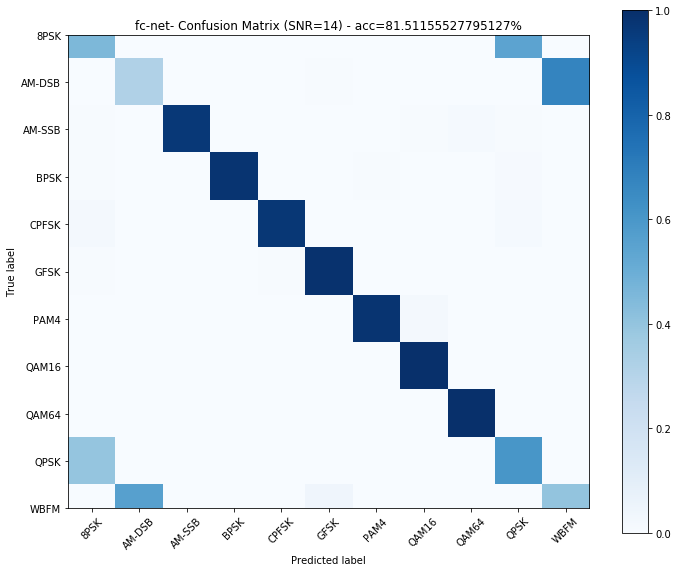

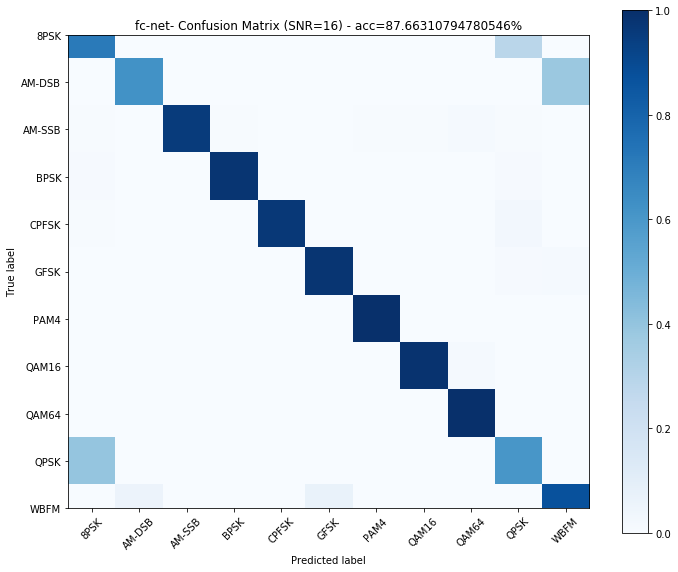

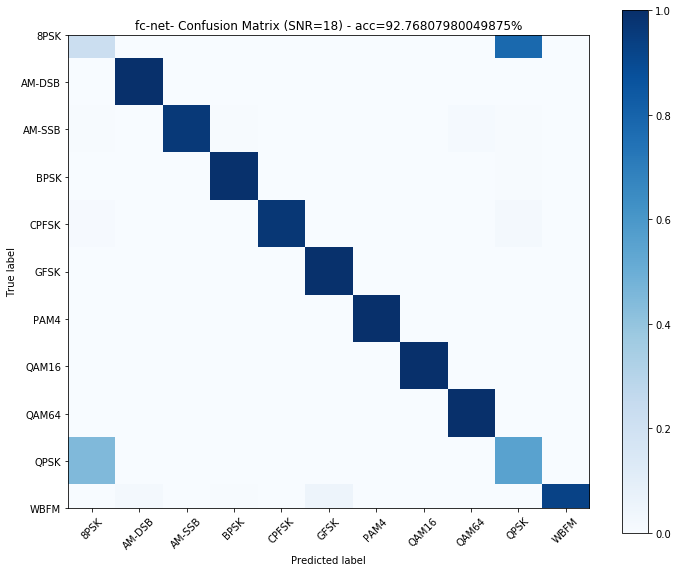

TypeError: float() argument must be a string or a number, not 'dict_keys'

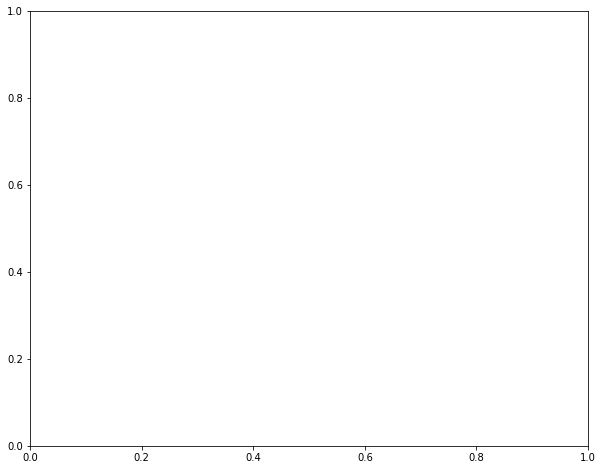

In [26]:
fc_model_evaluater.print_summary()

In [37]:
# derivative features
fc_devmodel = build_fc_net(X_devtrain.shape[1],X_devtrain.shape[2])
fc_devmodel_evaluater = ModelEvaluater(fc_devmodel, X_devtrain, y_devtrain, X_devtest, y_devtest, labels_devtest, labels, 1024, 10, 'fc-net' )
fc_devmodel_evaluater.fit(30,fit_all= True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 186)               47802     
_________________________________________________________________
dense_23 (Dense)             (None, 128)               23936     
_________________________________________________________________
dense_24 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_6 (Batch (None, 64)                256       
_________________________________________________________________
dense_25 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
__________

In [23]:
fc_devmodel_evaluater.print_summary()

NameError: name 'fc_devmodel_evaluater' is not defined

In [40]:
fc_fftmodel = build_fc_net(X_inttrain.shape[1],X_inttrain.shape[2])
fc_fftmodel_evaluater = ModelEvaluater(fc_intmodel, X_inttrain, y_inttrain, X_inttest, y_inttest, labels_inttest, labels, 1024, 10, 'fc-net' )
fc_fftmodel_evaluater.fit(30,fit_all= True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 186)               71610     
_________________________________________________________________
dense_33 (Dense)             (None, 128)               23936     
_________________________________________________________________
dense_34 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_8 (Batch (None, 64)                256       
_________________________________________________________________
dense_35 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
__________

In [ ]:
fc_fftmodel_evaluater.print_summary()

In [22]:
fc_compmodel = build_fc_net(X_comptrain.shape[1],X_comptrain.shape[2])
fc_compmodel_evaluater = ModelEvaluater(fc_compmodel, X_comptrain, y_comptrain, X_comptest, y_comptest, labels_comptest,labels, 1024, 10, 'fc-net' )
fc_compmodel_evaluater.fit(30,fit_all= True)

NameError: name 'X_comptrain' is not defined

In [21]:
fc_compmodel_evaluater.print_summary()

NameError: name 'fc_compmodel_evaluater' is not defined

In [1]:
fc_compmodel_evaluater.print_summary()

NameError: ignored